In [1]:
import pdb # 디버깅코드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset

데이터 : 스마트폰, 이마, 색소침착, 선발데이터(0, 2) 균형<br>
내  용 : 배치 정규화 진행 기울기 소실 방지<br>
결  과 : 검증세트가 1:1 비율인데  정확도가 76%까지 나오는 것을 확인

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
# 학습 데이터 준비 1. 스마트폰, 전면, 이마, 메타데이터 전체

import pickle

path = "/content/drive/MyDrive/Human_Final_Project/Data/Train_Data_Sets_02.pkl"
with open(path, "rb") as pickle_file:
    train_data_sets = pickle.load(pickle_file)
    print("데이터 로드 완료!!")

데이터 로드 완료!!


In [5]:
def data_selector(data_sets, target):
    """
    data_sets : {'Images': dict, 'Metadata': dict}
    target : [0, 2] 리스트형식으로 입력
    """

    # 원하는 타겟의 파일이름을 저장하기 위한 리스트 생성
    keys = []
    for idx, file_name in enumerate(data_sets["Metadata"]):
        pig = data_sets["Metadata"][file_name]['annotations']['forehead_pigmentation']
        # 타겟리스트안에 있는 파일명만 키에 저장
        if pig in target:
            keys.append(file_name)

    #값을 저장할 딕셔너리 생성
    selected_data = {}
    image = {}
    meta = {}

    #앞에서 생성한 키를 이용하여 데이터셋에서 파일명에 해당하는 데이터 추출
    for id in keys:
        image[id] = data_sets["Images"][id]
        meta[id] = data_sets["Metadata"][id]
    selected_data["Images"] = image
    selected_data["Metadata"] = meta

    from collections import Counter

    # 전체 데이터셋의 타겟 분포 확인
    targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in selected_data["Metadata"].values()]
    target_distribution = Counter(targets)

    # 분포 출력
    print("Target Distribution (Class Count):")
    for target, count in sorted(target_distribution.items()):
        print(f"Class {target}: {count}")

    # 시각화를 위한 matplotlib 사용
    import matplotlib.pyplot as plt

    classes = sorted(target_distribution.keys())
    counts = [target_distribution[c] for c in classes]

    plt.bar(classes, counts, tick_label=[f"Class {c}" for c in classes])
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Target Distribution")
    plt.show()

    return selected_data

In [2]:
train_data = data_selector(train_data_sets, [0, 2])
list(train_data['Metadata'].keys())[:5]

NameError: name 'data_selector' is not defined

In [7]:
# 검증 데이터 준비 1. 스마트폰, 전면, 이마, 메타데이터 전체
path = "/content/drive/MyDrive/Human_Final_Project/Data/Val_Data_Sets_02.pkl"
with open(path, "rb") as pickle_file:
    val_data_sets = pickle.load(pickle_file)
    print("데이터 로드 완료!!")

데이터 로드 완료!!


Target Distribution (Class Count):
Class 0: 21
Class 2: 21


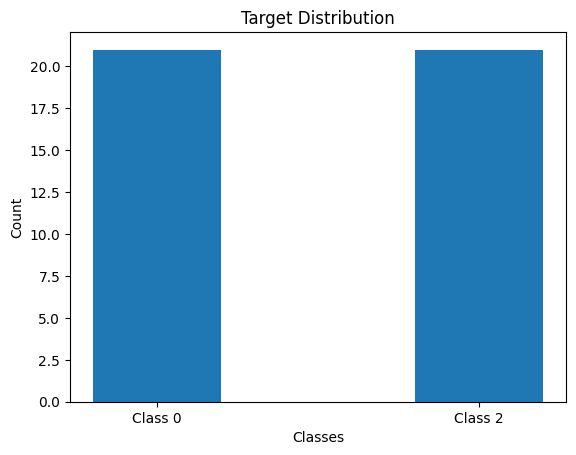

['0013_03_F_01',
 '0061_03_F_01',
 '0072_03_F_01',
 '0111_03_F_01',
 '0117_03_F_01']

In [11]:
val_data = data_selector(val_data_sets, [0, 2])
list(val_data['Metadata'].keys())[:5]

In [12]:
# 데이터 준비 1.
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data_sets):
        """
        Args:
            data_sets (dict): {'Images': dict, 'Metadata': dict}
        """
        self.images = data_sets['Images']
        self.metadata = data_sets['Metadata']
        self.keys = list(self.images.keys())  # 공통 키 목록
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        image = self.images[key]
        if self.transform:
            image = self.transform(image)

        target = torch.tensor(self.metadata[key]['annotations']['forehead_pigmentation'], dtype=torch.float32)  # 타겟 텐서
        return image, target


In [14]:
#데이터셋 생성
dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)

In [15]:
len(dataset)

338

In [16]:
# 첫 5개의 샘플 확인
for idx, (image, target) in enumerate(dataset):
    if idx < 5:
        print(f"샘플 {idx}:")
        print("이미지 텐서 크기:", image.shape)
        print("타겟 값:", target)

샘플 0:
이미지 텐서 크기: torch.Size([3, 224, 224])
타겟 값: tensor(0.)
샘플 1:
이미지 텐서 크기: torch.Size([3, 224, 224])
타겟 값: tensor(0.)
샘플 2:
이미지 텐서 크기: torch.Size([3, 224, 224])
타겟 값: tensor(2.)
샘플 3:
이미지 텐서 크기: torch.Size([3, 224, 224])
타겟 값: tensor(0.)
샘플 4:
이미지 텐서 크기: torch.Size([3, 224, 224])
타겟 값: tensor(2.)


In [17]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

In [18]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [19]:
class SkinNet(nn.Module):
    def __init__(self):
        super(SkinNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)  # 크기를 줄이는 Pooling Layer

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # 수정된 입력 크기
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)  # 추가 Pooling 적용


        x = x.view(x.size(0), -1)  # Flatten


        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [20]:
model = SkinNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(model)

SkinNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2):

In [22]:
def train(model, train_loader, optimizer):
    loss_total = 0
    correct_total = 0
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # 누적 손실 및 정확도 계산
        loss_total += loss.item()
        predicted_values = output.max(1, keepdim=True)[1]
        correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
        correct_total += correct

        if idx % 10 == 0:
            print(f"Batch : {idx}, Loss : {loss.item()}")

        # 에폭 종료 후 평균 손실 및 정확도 계산
    loss_total /= len(train_loader)  # 배치 개수로 나누어 평균 계산
    accuracy = correct_total / len(train_loader.dataset)  # 전체 데이터셋에서 정확도 계산

    # 마지막 배치 후 결과 출력
    print(f"Epoch Finished - Loss: {loss_total:.4f}, Accuracy: {accuracy:.4f}")

    return loss_total, accuracy

In [23]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # evaluation mode로 설정 -> batch-normalization, drop-out 수행 중지
    with torch.no_grad(): # 가중치 업데이트 수행 중지
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            # pdb.set_trace()
            correct_total += correct

    loss_total /= ( len(val_dataset) / 4 )
    accuracy = correct_total / len(val_dataset)

    return loss_total, accuracy



In [24]:
# 학습 실행

for epoch in range(10):
    train(model, train_loader, optimizer)
    val_loss, val_accuracy = evaluate(model, test_loader)
    print(f"Epoch : {epoch + 1}, val_Loss: {val_loss}, val_Accuracy : {val_accuracy}")

Batch : 0, Loss : 1.1207526922225952
Batch : 10, Loss : 0.4610796272754669
Batch : 20, Loss : 0.3316979706287384
Batch : 30, Loss : 2.209052085876465
Batch : 40, Loss : 1.02793550491333
Batch : 50, Loss : 0.2975938022136688
Batch : 60, Loss : 0.9880189299583435
Batch : 70, Loss : 0.5675761699676514
Batch : 80, Loss : 0.6602216958999634
Epoch Finished - Loss: 0.6282, Accuracy: 0.6834
Epoch : 1, val_Loss: 0.7226115011033558, val_Accuracy : 0.6190476190476191
Batch : 0, Loss : 0.452096164226532
Batch : 10, Loss : 0.5517021417617798
Batch : 20, Loss : 0.4848479926586151
Batch : 30, Loss : 0.06204675883054733
Batch : 40, Loss : 0.7397550344467163
Batch : 50, Loss : 0.3452188968658447
Batch : 60, Loss : 0.2145807296037674
Batch : 70, Loss : 0.47835540771484375
Batch : 80, Loss : 0.7711457014083862
Epoch Finished - Loss: 0.5750, Accuracy: 0.7101
Epoch : 2, val_Loss: 0.659679658356167, val_Accuracy : 0.6190476190476191
Batch : 0, Loss : 0.33765003085136414
Batch : 10, Loss : 0.5020960569381714